## 2.6 Doping,  k=-49.0 to 49.0

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import h5py

from scipy import ndimage

import time
import sys
sys.path.append('/home/shared/XTEC/src/xtec')

%load_ext autoreload
%autoreload 2

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from GMM import GMM


In [2]:
# read data, and Qh,Qk,Ql values
DIR = '/home/shared/STEM_Xray_data/xray_from_Josh_Straquadine/PdxErTe3_2x6/PdxErTe3_2x6_'
Tlist = [30,40,50,60,70,80,90,100,125,150,175,200,215,230,250,275,300] #T=30
filepaths = [DIR + str(T) + 'K.nxs' for T in Tlist]
h5py_data_key = 'entry/transform/data/'


doc = h5py.File(filepaths[0], 'r')
    
Qh=np.array(doc['entry/transform']['Qh'])
Qk=np.array(doc['entry/transform']['Qk'])
Ql=np.array(doc['entry/transform']['Ql'])



In [3]:
H_Bragg_loc=np.array(Qh%1==0)
K_Bragg_loc=np.array(Qk%1==0)
L_Bragg_loc=np.array(Ql%1==0)

Qh_Bragg=Qh[np.where(H_Bragg_loc)]
Qk_Bragg=Qk[np.where(K_Bragg_loc)]
Ql_Bragg=Ql[np.where(L_Bragg_loc)]



H_Bragg_ind=np.array(np.where(H_Bragg_loc)).flatten()
L_Bragg_ind=np.array(np.where(L_Bragg_loc)).flatten()
K_Bragg_ind=np.array(np.where(K_Bragg_loc)).flatten()

Qk_ind=K_Bragg_ind[abs(Qk[K_Bragg_ind])<=49]
cpu_counter=range(len(Qk_ind))

print('Data considered here:')
print('Qh = ', Qh)
print('Ql = ', Ql)
print('Qk = ', Qk[Qk_ind])



Data considered here:
Qh =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Ql =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Qk =  [-49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36.
 -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22.
 -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.
  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.
   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
  49.]


In [5]:
def Process_data(Thresh_cutoff,delta_hl,delta_k,cpu_counter):
    
    # data averaged between k-delta_k:Qk+delta_k+1 slices
    K_Bragg=Qk[Qk_ind[cpu_counter]]
    HL_Bragg_ind=[(H_Bragg_ind[q], L_Bragg_ind[r])  for q in range(len(H_Bragg_ind)) for r in range(len(L_Bragg_ind))]

    
    
    data_slice={}
    data = []

    for filepath in filepaths:
        doc = h5py.File(filepath, 'r')
        dataT = doc[h5py_data_key][:,Qk_ind[cpu_counter]-delta_k:Qk_ind[cpu_counter]+delta_k+1,:]
        data.append(dataT)
        doc.close()
    
    data = np.array(data) 
    I=np.mean(data,axis=2)
    I = np.squeeze(I)
    
    
    masked_zeros    = Mask_Zeros(I,'any_zeros')
    if(Thresh_cutoff==None):
        threshold = Threshold_Background(masked_zeros)   # Find cutoff independently for each data
        Thresh_cutoff=threshold.LogI_cutoff
    else:
        threshold = Threshold_Background(masked_zeros,1,'No Thresh',100,Thresh_cutoff) #Use the cutoff previously estimated 

    

    data_slice['I']=I
    data_slice['Tlist'] = Tlist
    
    
    
    nT=I.shape[0]
    nH=I.shape[1]
    nL=I.shape[2]
    
    
    data_slice['I_tot']=np.sum(I)/nT
    
    
    # apply masks to separate c and a axis, as well as the K=even and K = odd pattern
    #I_a=np.zeros((nT, nH,  nL))
    #I_c=np.zeros((nT, nH,  nL))
    
    #if(K_Bragg%2==0):                      
    #    A_mask=mask_A*mask_odd                       
    #    C_mask=mask_C*mask_odd                       
    #else:
    #    A_mask=mask_A*mask_even                       
    #    C_mask=mask_C*mask_even                       
      
        
    #for i in range(0,nT):
    #    I_a[i,:,:]=I[i,:,:]*A_mask
    #    I_c[i,:,:]=I[i,:,:]*C_mask
    
    # No Mask
    I_c=I
    
    ###########################################################################
    # I_c (Intensity along c axis, containing CDW-1)
    ###########################################################################
    
    masked_c    = Mask_Zeros(I_c,'any_zeros')
    threshold_c = Threshold_Background(masked_c,1,'No Thresh',100,Thresh_cutoff) #Use the cutoff previously estimated 

    num_thresholded  = threshold_c.data_thresholded.shape[1]
    if num_thresholded  == 0:
        print('Thresholding fail')
        return data_slices
    else:
        #print('Num data thresholded=', num_thresholded)
        data_slice['threshold_c']=threshold_c
    
    
    
    max_num_features = 10000
    sector_id=int(cpu_counter)*max_num_features
    
    
    # identify connected features 
    structure_element = np.ones((3,3))    # to identify features if they are connected, even diagonally

    labeled_array, num_features = ndimage.label(threshold_c.thresholded,structure=structure_element)
                    # threshold.thresholded[H,L]=1 if above thresh cutoff 
                    # labelled_array[H,L] has connected features (#num_features) marked by different integers 
    if(num_features>max_num_features):
        print('num features too large', num_features,max_num_features)
        return data_slice
    
    
    
    

    Bragg_labels = [labeled_array[ind] for ind in HL_Bragg_ind]   # labels at Brag_loc
    Bragg_labels = [i for i in Bragg_labels if i != 0]
    Bragg_labels = np.unique(Bragg_labels)



    NonBragg_labels = (np.setdiff1d(list(range(1,num_features)),Bragg_labels)).tolist()  # labels not in Brag_labels
    NonBragg_labels = [i for i in NonBragg_labels if i != 0]
    NonBragg_labels = np.unique(NonBragg_labels)


    
    Bragg_mask    = np.isin(labeled_array,Bragg_labels)           # returns true for labeled arrays that match one of Bragg_labels
    Bragg_ind     = np.array(np.where(Bragg_mask)).transpose()    # h,l indices of   Bragg data, (#Bragg_data, 2) 

    NonBragg_mask = np.isin(labeled_array,NonBragg_labels)           # returns true for labeled arrays that match  NonBragg_labels
    NonBragg_ind  = np.array(np.where(NonBragg_mask)).transpose()    # h,l indices of non Bragg data, (#non_Bragg_data, 2) 


    Bragg_data    = I[:,Bragg_mask]                               # shape=(#T, #bragg_data)   
    
    NonBragg_data = I[:,NonBragg_mask]                            # shape=(#T, #non_bragg_data)  



    data_slice['labeled_array']=labeled_array+sector_id
    data_slice['num_features']=num_features
    data_slice['Bragg_labels']=Bragg_labels+sector_id
    data_slice['NonBragg_labels']=NonBragg_labels+sector_id
    
    
    
    data_slice['Bragg_data']=Bragg_data
    data_slice['Bragg_ind'] = Bragg_ind
    
    data_slice['NonBragg_data']=NonBragg_data
    data_slice['NonBragg_ind'] = NonBragg_ind
    
    
    num_NB=len(NonBragg_labels)
    
    # Find peak tot, peak avg, and peak max intensity, max intensity

    NB_avg = np.zeros((nT,num_NB))       # peak averaged non bragg int, shape=(num_T, num_NB)
    NB_tot = np.zeros((nT,num_NB))
    NB_max = np.zeros((nT,num_NB))
    NB_BG  = np.zeros((nT,num_NB))

    NB_label = np.zeros(num_NB) # labels of peak averaged non bragg intensities
    NB_mom = np.zeros((num_NB,3)) # labels of peak averaged non bragg intensities
    
    
    
    
    
    j=0
    for i in NonBragg_labels:
        label_i    = np.isin(labeled_array,i)
        data_i     = I[:,label_i]
        data_i     = data_i.reshape((data_i.shape[0],np.prod(data_i.shape[1:])))
    
        NB_tot[:,j] = np.sum(data_i, axis=1)   
        NB_avg[:,j] = np.mean(data_i, axis=1)  
        NB_max[:,j] = np.amax(data_i, axis=1) 
        
        
        I_misc     = np.mean(I[0:3],axis=0)*label_i
        P_ind = np.unravel_index(np.argmax(I_misc, axis=None), I_misc.shape)
        NB_mom[j,0] = P_ind[0] # H
        NB_mom[j,1] = P_ind[1] # L
        NB_mom[j,2] = Qk_ind[cpu_counter]
        
        # find Background intensity in a delta (H) x delta (L) nb of the NB peaks
        h1=max(P_ind[0]-delta_hl,0)
        h2=min(P_ind[0]+delta_hl+1,nH-1)
        
        l1=max(P_ind[1]-delta_hl,0)
        l2=min(P_ind[1]+delta_hl+1,nL-1)
        for iT in range(nT):
            BG=I[iT,h1:h2,l1:l2]*(1-threshold.thresholded[h1:h2,l1:l2]) # intensities outside the peak
            if(np.amax(BG)>0):
                x=BG[(BG>0)].flatten()
                BG_avg=np.mean(x)
                NB_BG[iT,j]=BG_avg
        
        NB_label[j]   = i              # label of the jth averaged Non Bragg data point, same as NonBragg_labels
        j+=1
    

    data_slice['NB_avg']=NB_avg
    data_slice['NB_tot'] = NB_tot
    data_slice['NB_max'] = NB_max
    data_slice['NB_mom'] = NB_mom
    data_slice['NB_BG']  = NB_BG # background intensity just outside the peak in a deltaxdelta neighborhood

    
    data_slice['NB_label']=NB_label+sector_id # unique label for this non bragg peak 
    
    
    
    print('Completed k=',K_Bragg, cpu_counter, I.shape)
    return data_slice
    

In [6]:
Qk_ind[0]

10

In [7]:

start_time = time.time()

import multiprocessing as mp
from functools import partial   # partial functions like: func(x,y,z), par=partial(func,2,3) gives par(1)= func(2,3,1)  

delta_hl=5
delta_k=1
Thresh_cutoff=None
Preprocessing = partial(Process_data,Thresh_cutoff,delta_hl,delta_k)
print('num of cpus', mp.cpu_count())
#pool = mp.Pool(mp.cpu_count())
pool = mp.Pool(mp.cpu_count()-4) # Leave a couple prcs free
processed_data = pool.map(Preprocessing,cpu_counter)
run_time = time.time() - start_time
print("Total Run Time:",run_time)





num of cpus 48
Completed k= -20.0 29 (17, 1001, 1001)
Completed k= -21.0 28 (17, 1001, 1001)
Completed k= -19.0 30 (17, 1001, 1001)
Completed k= -4.0 45 (17, 1001, 1001)
Completed k= -3.0 46 (17, 1001, 1001)

Completed k= -5.0 44 (17, 1001, 1001)Completed k= -17.0 32 (17, 1001, 1001)
Completed k= -45.0 4 (17, 1001, 1001)
Completed k= -49.0 0 (17, 1001, 1001)
Completed k= -48.0 1 (17, 1001, 1001)
Completed k= -46.0 3 (17, 1001, 1001)
Completed k= -15.0 
34 (17, 1001, 1001)Completed k= -34.0 15 (17, 1001, 1001)
Completed k= Completed k=-36.016 Completed k=Completed k=  -33.0-41.0 8 (17, 1001, 1001)
 -42.0 7 (17, 1001, 1001)13
 (17, 1001, 1001)
  (17, 1001, 1001)
Completed k= -43.0 6 Completed k=(17, 1001, 1001)
 -37.0 12 (17, 1001, 1001)
Completed k=
 -31.0 18 (17, 1001, 1001)
Completed k= -47.0 2 (17, 1001, 1001)Completed k= -16.0 33 (17, 1001, 1001)
Completed k= -35.0 14 (17, 1001, 1001)
Completed k= -40.0 9 (17, 1001, 1001)
Completed k= -38.0 11 (17, 1001, 1001)
Completed k= -39.0 10 

In [4]:
import pickle
#pickle.dump( processed_data, open( "processed_data_No_Mask_2x6.p", "wb" ) )
processed_data = pickle.load(open("processed_data_No_Mask_2x6.p", "rb" ) )


# CDW along c*

In [5]:
I_BG_list=[]
NB_avg_list = []
NB_tot_list = []
NB_max_list = []
NB_mom_list = []
NB_data_list=[]

NB_label_list = []
threshold_list=[]
labeled_array_list=[]

for num, slices in enumerate(processed_data):
    Tlist=slices['Tlist']
    #I_BG_list.append(slices['I_BG'])
    NB_data_list.append(slices['NonBragg_data'])
    NB_avg_list.append(slices['NB_avg'])
    NB_tot_list.append(slices['NB_tot'])
    NB_max_list.append(slices['NB_max'])
    NB_mom_list.append(slices['NB_mom'])
    
  
    NB_label_list.append(slices['NB_label'])
    
    threshold_list.append(slices['threshold_c'])
    labeled_array_list.append(slices['labeled_array'])

NB_avg  = np.hstack(NB_avg_list)  #(num_T, num_NB_data)
NB_tot  = np.hstack(NB_tot_list)  #(num_T, num_NB_data)
NB_max  = np.hstack(NB_max_list)  #(num_T, num_NB_data)
NB_mom  = np.vstack(NB_mom_list)  #(num_T, num_NB_data)

NB_data = np.hstack(NB_data_list)  #(num_T, num_NB_data)
#I_BG    = np.hstack(I_BG_list)  #(num_T, num_NB_data)

NB_label = np.hstack(NB_label_list)  #(num_NB_data) labels for the non bragg data

print(NB_avg.shape)
print(NB_tot.shape)
print(NB_max.shape)
print(NB_mom.shape)

print(NB_data.shape)
#print(I_BG.shape)



#I_BG_mean=np.mean(I_BG,axis=1)
#I_BG_std=np.std(I_BG,axis=1)
#print(I_BG_mean.shape)


(17, 35250)
(17, 35250)
(17, 35250)
(35250, 3)
(17, 321848)


## Clustering

In [8]:
x_train = np.array(Tlist)

#data_post_thresh = NB_avg

data_post_thresh = np.log(NB_avg)
data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0)) #threshold.Rescale_traj(data_post_thresh)
y_train=data_post_thresh_no_mean.transpose() 

print('Data shape',y_train.shape)


Data shape (35250, 17)


In [11]:
from sklearn import  mixture
ks = np.arange(2,15)
bics = []
print(y_train.shape)
for k in ks:
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='diag')
    gmm.fit(y_train)
    bics.append(gmm.bic(y_train))
    








(35250, 17)


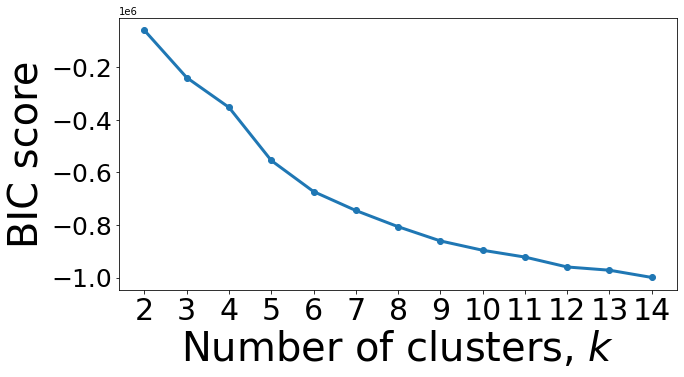

In [15]:
# Plot the data    
plt.figure(figsize=(10,5))
plt.plot(ks, bics,marker='o', lw=3)
plt.xlabel(r'Number of clusters, $k$',size=40)
plt.ylabel('BIC score',size=40)
plt.xticks(ks,fontsize=30);
plt.yticks(np.arange(-1e6,-0.1e6,0.2e6), fontsize=25);





Num per cluster [8472, 4337, 5809, 2770, 2755, 8557, 2550]


<module 'matplotlib.pyplot' from '/home/fs01/kmm537/XTEC_venv/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

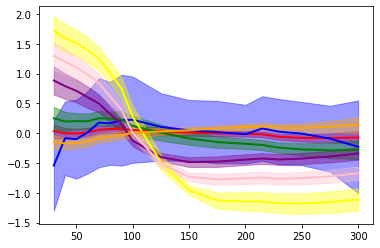

In [16]:
num_clusters = 7
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

In [21]:
import pickle
pickle.dump(clusterGMM, open( "First_clusterGMM_2x6_7C.p", "wb" ) )


Data shape (35250, 17)
Num per cluster [4182, 9111, 4161, 13196, 4600]


<module 'matplotlib.pyplot' from '/home/fs01/kmm537/XTEC_venv/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

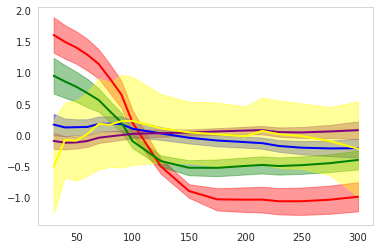

In [27]:


print('Data shape',y_train.shape)

#x_train = np.array(Tlist)
#y_train = threshold.data_high_std_dev.transpose()
#y_train = np.log(1+data_post_thresh)
#y_train = threshold.data_high_std_dev.transpose()/np.std(threshold.data_high_std_dev.transpose(),axis=1)[:,np.newaxis]
#y_train = data_post_thresh_no_mean.transpose()/np.std(data_post_thresh_no_mean.transpose(),axis=1)[:,np.newaxis]

num_clusters = 5
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

Data shape (35250, 17)
Num per cluster [7480, 4609, 9027, 14134]


<module 'matplotlib.pyplot' from '/home/fs01/kmm537/XTEC_venv/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

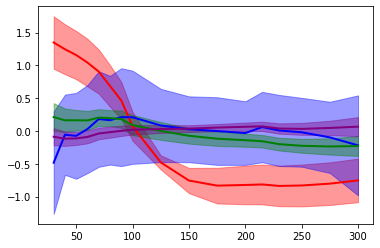

In [17]:


print('Data shape',y_train.shape)

#x_train = np.array(Tlist)
#y_train = threshold.data_high_std_dev.transpose()
#y_train = np.log(1+data_post_thresh)
#y_train = threshold.data_high_std_dev.transpose()/np.std(threshold.data_high_std_dev.transpose(),axis=1)[:,np.newaxis]
#y_train = data_post_thresh_no_mean.transpose()/np.std(data_post_thresh_no_mean.transpose(),axis=1)[:,np.newaxis]

num_clusters = 4
clusterGMM = GMM(y_train,num_clusters)
clusterGMM.RunEM()
print('Num per cluster',clusterGMM.num_per_cluster)
cluster_assignments = clusterGMM.cluster_assignments
clusterGMM.Plot_Cluster_Results_traj(x_train)

In [6]:
import pickle
#pickle.dump(clusterGMM, open( "First_clusterGMM_2x6_4C.p", "wb" ) )
clusterGMM=pickle.load(open( "First_clusterGMM_2x6_4C.p", "rb" ))
cluster_assignments = clusterGMM.cluster_assignments


## save all filtered trajectories 

In [9]:
CDW_clusters=[0,2]


T = np.array(Tlist)
I_raw = NB_avg
I_rescaled=y_train

cluster_num=clusterGMM.cluster_num
GMM_means = [clusterGMM.cluster[k].mean for k in range(cluster_num)]
GMM_cov = [clusterGMM.cluster[k].cov for k in range(cluster_num)]


CDW_trajs  = np.isin(cluster_assignments, CDW_clusters)
I_rescaled_CDW=I_rescaled[CDW_trajs,:]


import pickle
obj={}
obj['Temp']=T
obj['I_raw']=I_raw
obj['I_rescaled']=I_rescaled
obj['I_rescaled_CDW']=I_rescaled_CDW
obj['cluster_num']=cluster_num
obj['GMM_means']=GMM_means
obj['GMM_cov']=GMM_cov
obj['cluster_assignments']=clusterGMM.cluster_assignments
obj['CDW_clusters']=CDW_clusters

pickle.dump( obj, open( "2x6_cluster_traj_CDW_1_CDW_2.p", "wb" ) )





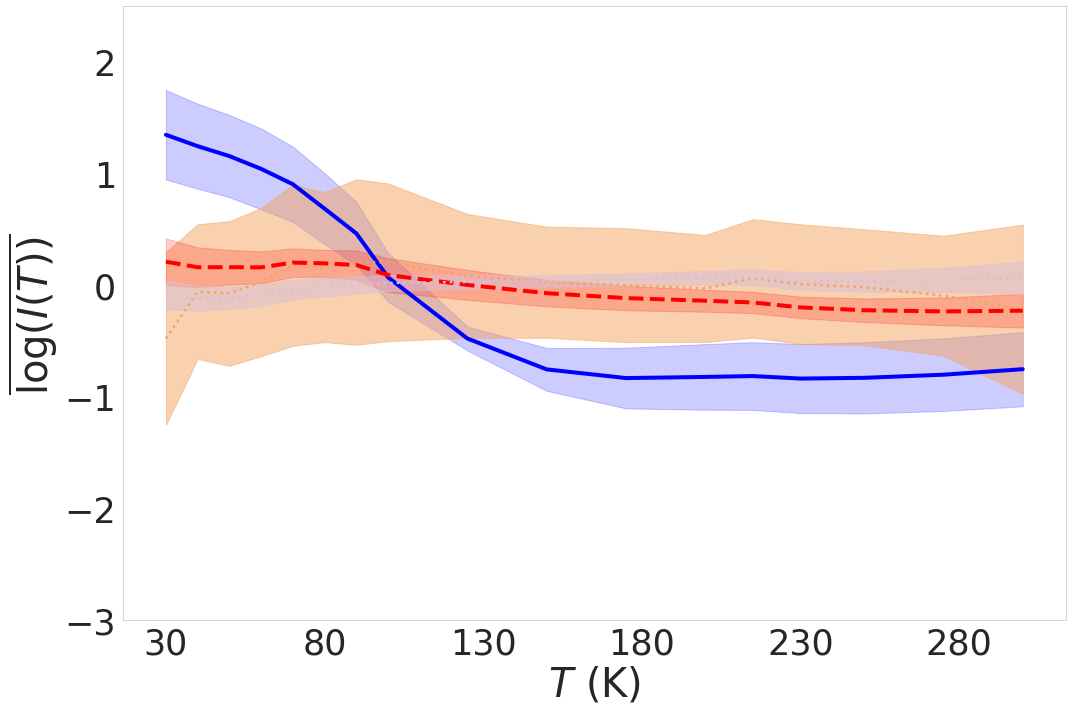

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))



x_train=np.array(Tlist)

color_list = ['blue','sandybrown' , 'red', 'thistle', 'grey', 'orange', 'pink', 'black', 'grey', 'cyan']
line_list= ['-',':','--',':',':',':']
lw_list=[4,2.5,4,2.5,2.5,2.5]
alpha_list=[0.2,0.5,0.2,0.5,0.2,0.2,0.2]
for i in range(clusterGMM.cluster_num):
    cluster_mask_i = (clusterGMM.cluster_assignments == i)
    yc = y_train.transpose()
    yc=yc[:,cluster_mask_i]

    yc_plot=np.mean(yc,axis=1).flatten()
    std=np.std(yc,axis=1).flatten()
    plt.plot(np.array(Tlist),yc_plot,color=color_list[i], lw=lw_list[i],marker=' ', linestyle=line_list[i]);
    plt.gca().fill_between(x_train, yc_plot-std, yc_plot+std ,color=color_list[i], alpha=alpha_list[i])


plt.xlabel('$T$ (K)',size=40)
plt.ylabel(r'$\overline{\log\left(I(T)\right)}$',size=40)
plt.xticks(np.arange(30, 310, 50), fontsize=35)
plt.yticks(fontsize=35)
plt.ylim([-3,2.5])
#plt.yscale('log')
#plt.ylim([30,3000])

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=35)
#plt.legend(loc='best', fontsize=30,frameon=False)

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

plt.savefig('CDW_1_2_2x6.svg')   
plt.savefig('CDW_1_2_2x6.png',dpi=600)   


## undo rescaling

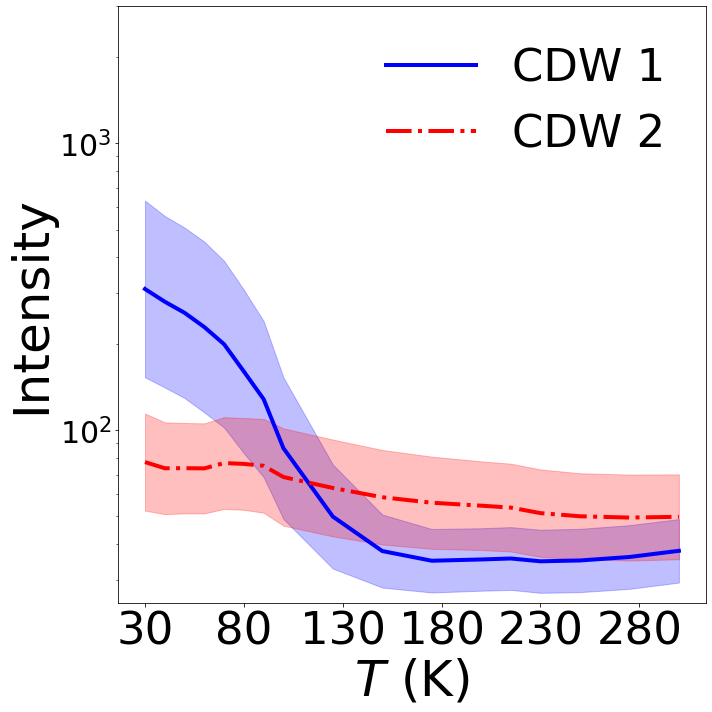

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
#color_list = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']
color_list = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']
data=np.log10(NB_avg)
x_train=np.array(Tlist)
std_dev_num=1



# ................CDW-1............................
i=0
cluster_mask_i = (clusterGMM.cluster_assignments == i)
yc_plot=np.mean(data[:,cluster_mask_i],axis=1).flatten()
std= np.std(data[:,cluster_mask_i],axis=1).flatten()   

plt.plot(x_train,10**yc_plot,color='blue', lw=4,linestyle='-',marker=' ',markersize=8, label='CDW 1');
plt.gca().fill_between(x_train, 10**(yc_plot-std), 10**(yc_plot+std) , color='blue', alpha=0.25)

#xc=[260]
#yc=(10**yc_plot)[-4]
#plt.plot(xc,yc,marker="o", markersize=15,color='black',linestyle='None')



# ................CDW-2............................

i=2

cluster_mask_i = (clusterGMM.cluster_assignments == i)
yc_plot=np.mean(data[:,cluster_mask_i],axis=1).flatten()
std= np.std(data[:,cluster_mask_i],axis=1).flatten()   

plt.plot(x_train,10**yc_plot,color='red', lw=4,linestyle='-.', marker=' ',markersize=10,label='CDW 2');
plt.gca().fill_between(x_train, 10**(yc_plot-std), 10**(yc_plot+std) , color='red', alpha=0.25)





#xc=[135]
#yc=(10**yc_plot)[4]
#plt.plot(xc,yc,marker='s', markersize=15,color='black',linestyle='None')








plt.xlabel('$T$ (K)',size=50)
plt.ylabel(r'Intensity',size=50)
plt.xticks(np.arange(30, 310, 50), fontsize=45)
plt.yticks(fontsize=30)

plt.yscale('log')
plt.ylim([25,3000])

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=35)
plt.legend(loc='best', fontsize=45,frameon=False)

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

plt.savefig('CDW_1_2_2x6.svg')   
plt.savefig('CDW_1_2_2x6.png',dpi=600)   



# Look at momentum distribution of CDW

In [25]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_slice(K_block):
    # ...............Just for a lighter shade of sky blue for background...................................

    K=Qk[Qk_ind[K_block]]
    print('K=', K)
    
    plotting_slice = threshold_list[K_block].thresholded.copy()
    labeled_array=labeled_array_list[K_block]


    for k in range(cluster_num):
        cluster_labels = NB_label[(cluster_assignments == k)]
        cluster_mask   = np.isin(labeled_array,cluster_labels)           # returns true for labeled arrays that match  NonBragg_labels
        plotting_slice[cluster_mask] = k+2
    
    color_list = ['white','whitesmoke','blue','whitesmoke','red', 'whitesmoke','whitesmoke', 'whitesmoke', 'whitesmoke']
    cluster_cmap = colors.ListedColormap(color_list)
    
    bounds = []
    for i in range(len(color_list)+1):
        bounds.append(i-0.5)
    norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




    fig=plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    y_major_ticks = np.array(Qh_Bragg)
    x_major_ticks = np.array(Ql_Bragg)
    ax.set_yticks(y_major_ticks)
    ax.set_xticks(x_major_ticks)
    if(K%2==0): 
        ax.set_title(r'$K$ = '+str(K), fontsize=25)
    else:
        ax.set_title(r'$K$ = '+str(K), fontsize=25)
        
    ax.set_xlabel('$H$ (r.l.u.)', fontsize=25)
    ax.set_ylabel('$L$ (r.l.u.)', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    #plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]])
    
    plt.imshow(plotting_slice[775:925,500+75:500+225],origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[500+75], Ql[500+225],Qh[775], Qh[925]])
    plt.grid(color='#999999', linestyle='-', alpha=0.05)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.tight_layout()

    plt.savefig('CDW_12_slice_K_'+str(K)+'_2x6.svg') 
    plt.savefig('CDW_12_slice_K_'+str(K)+'_2x6.png',dpi=600) 
    



    

K= 1.0
K= 2.0
K= 3.0
K= 4.0


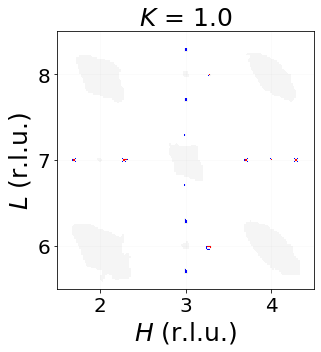

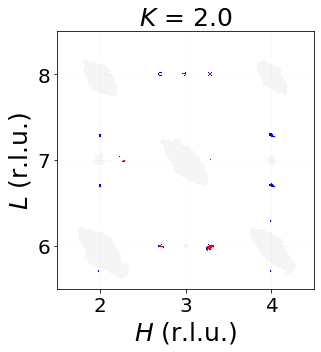

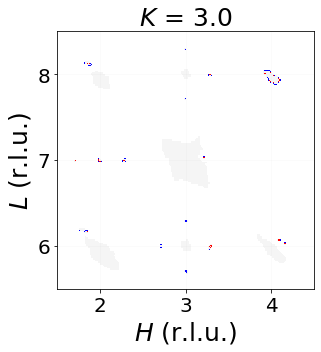

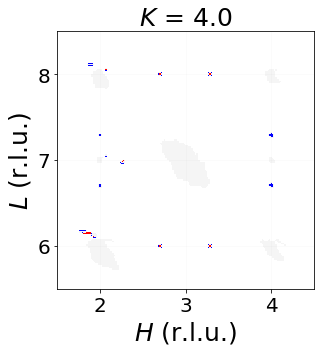

In [26]:
plot_slice(50)

plot_slice(51)
plot_slice(52)
plot_slice(53)


# Find momentum distribution of each cluster in 1BZ

In [37]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})

def plot_1BZ_dist(H_axis=True):
    if(H_axis):
        Q=Qh[NB_mom[:,1].astype(int)]+0.5
        xlabel='H (reduced zone)'
    else:
        Q=Ql[NB_mom[:,0].astype(int)]+0.5
        xlabel='L (reduced zone)'

    Q_1BZ=np.mod(Q,1)-0.5

        
    color_list = ['blue','sandybrown' , 'red', 'thistle', 'grey', 'orange', 'pink', 'black', 'grey', 'cyan']


    for i in range(clusterGMM.cluster_num):
        cluster_mask_i = (clusterGMM.cluster_assignments == i)
        yc=Q_1BZ[cluster_mask_i]
        
        plt.figure(figsize=(3,2),dpi=600)
    
        sns.histplot(data=yc, stat='percent',bins=50,edgecolor=None, color=color_list[i],line_kws={'linewidth': 3})
    
        plt.yscale("linear")
        
        plt.xlabel(xlabel,size=20)
        plt.ylabel('%',size=20)
        plt.ylim([0,50])
        plt.xticks(np.arange(-0.3,0.31,0.3),size=18)
        plt.yticks(size=18)
    
        ax=plt.gca()
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(True)
        ax.yaxis.set_major_locator(MultipleLocator(20))

    

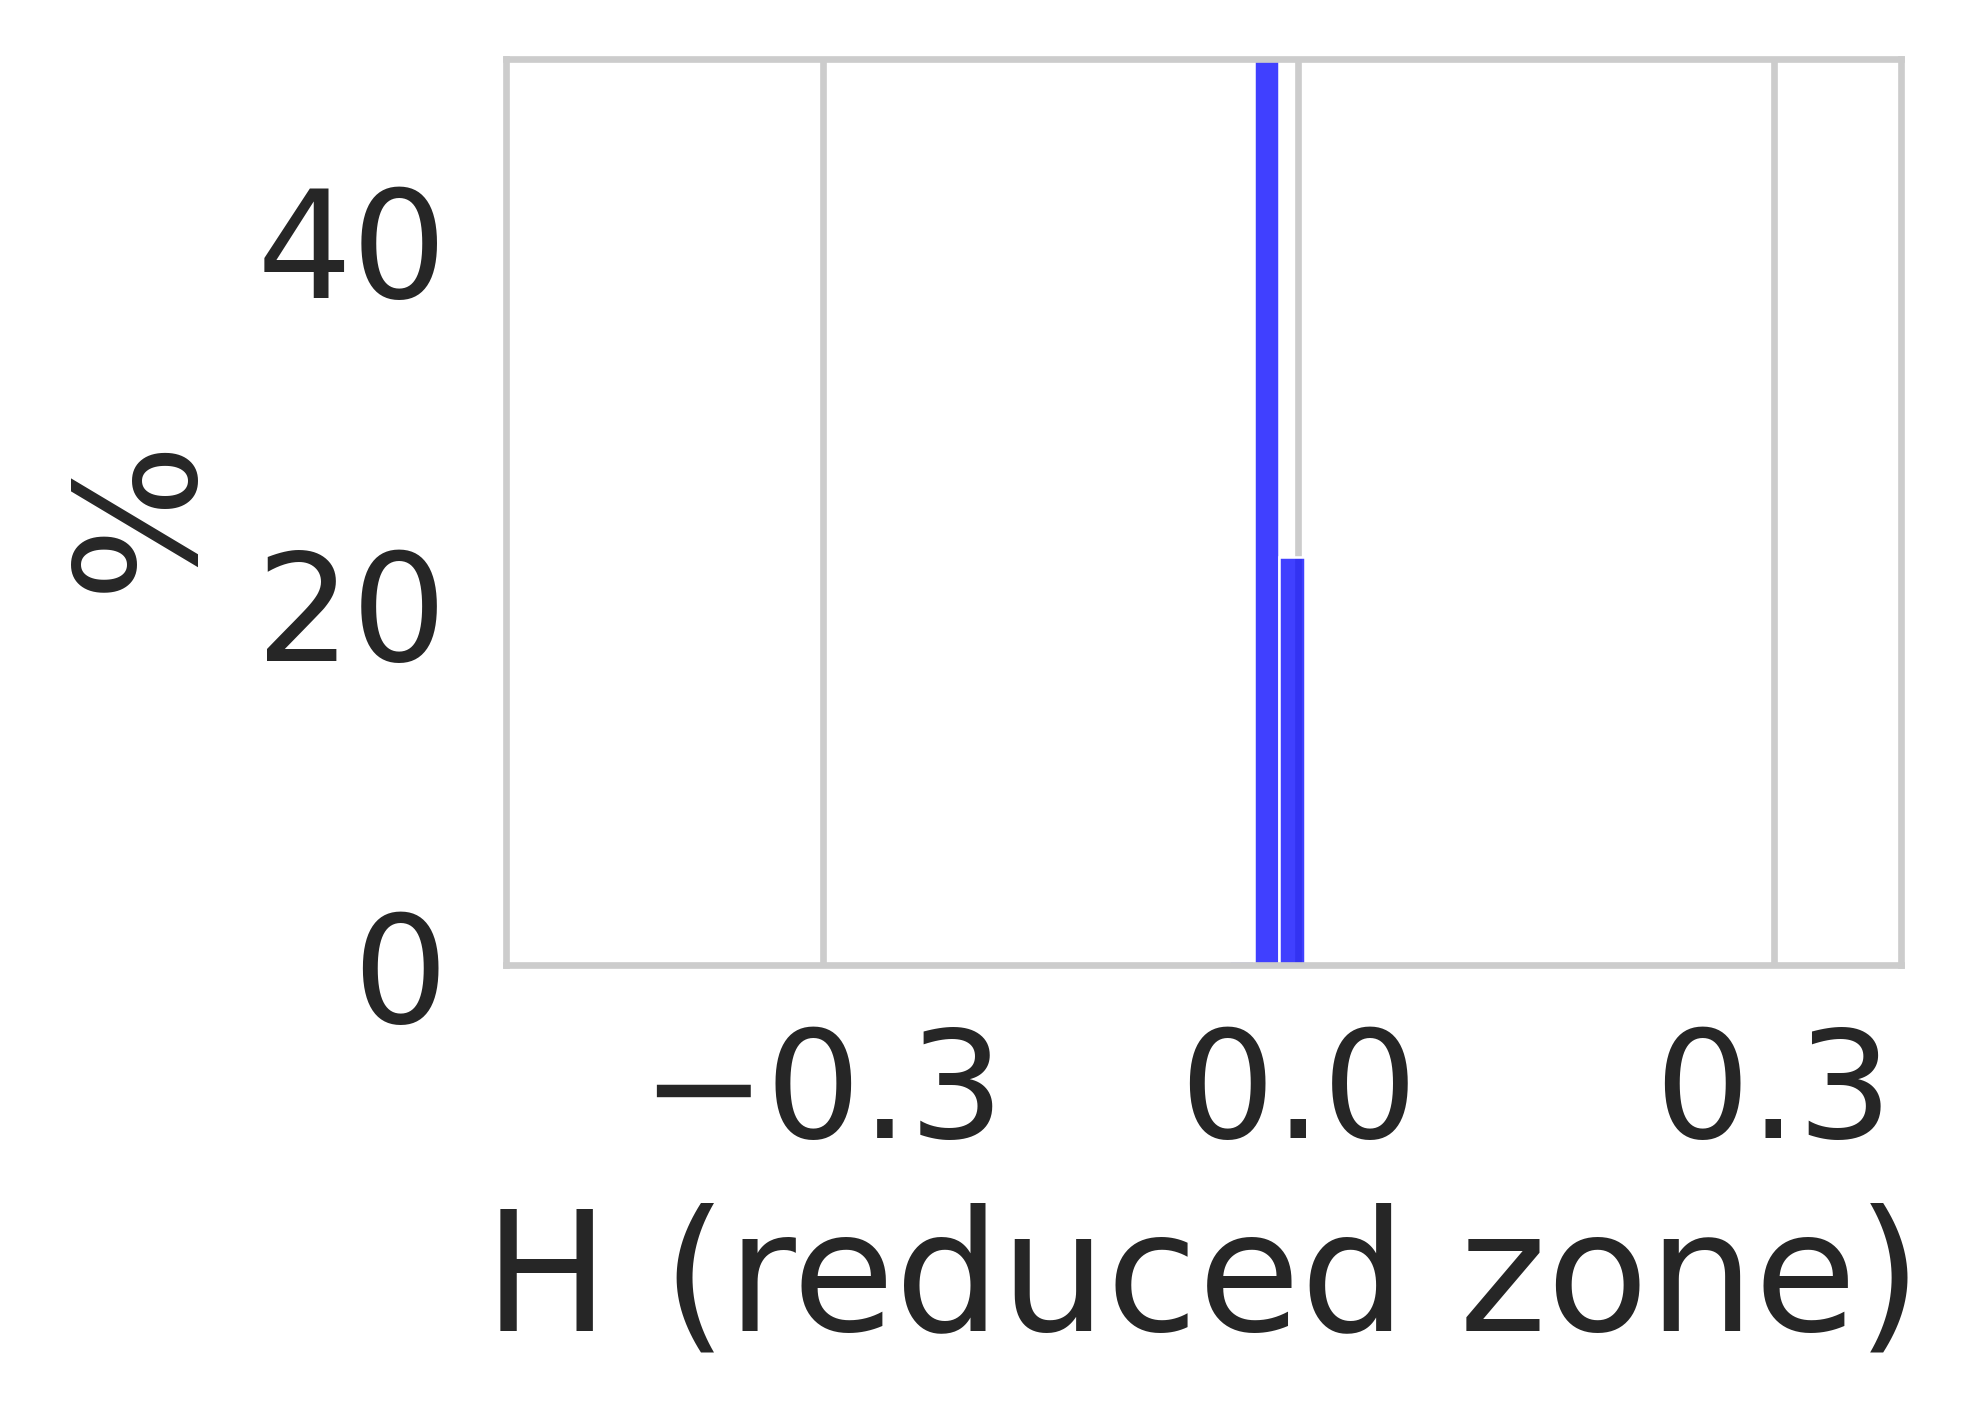

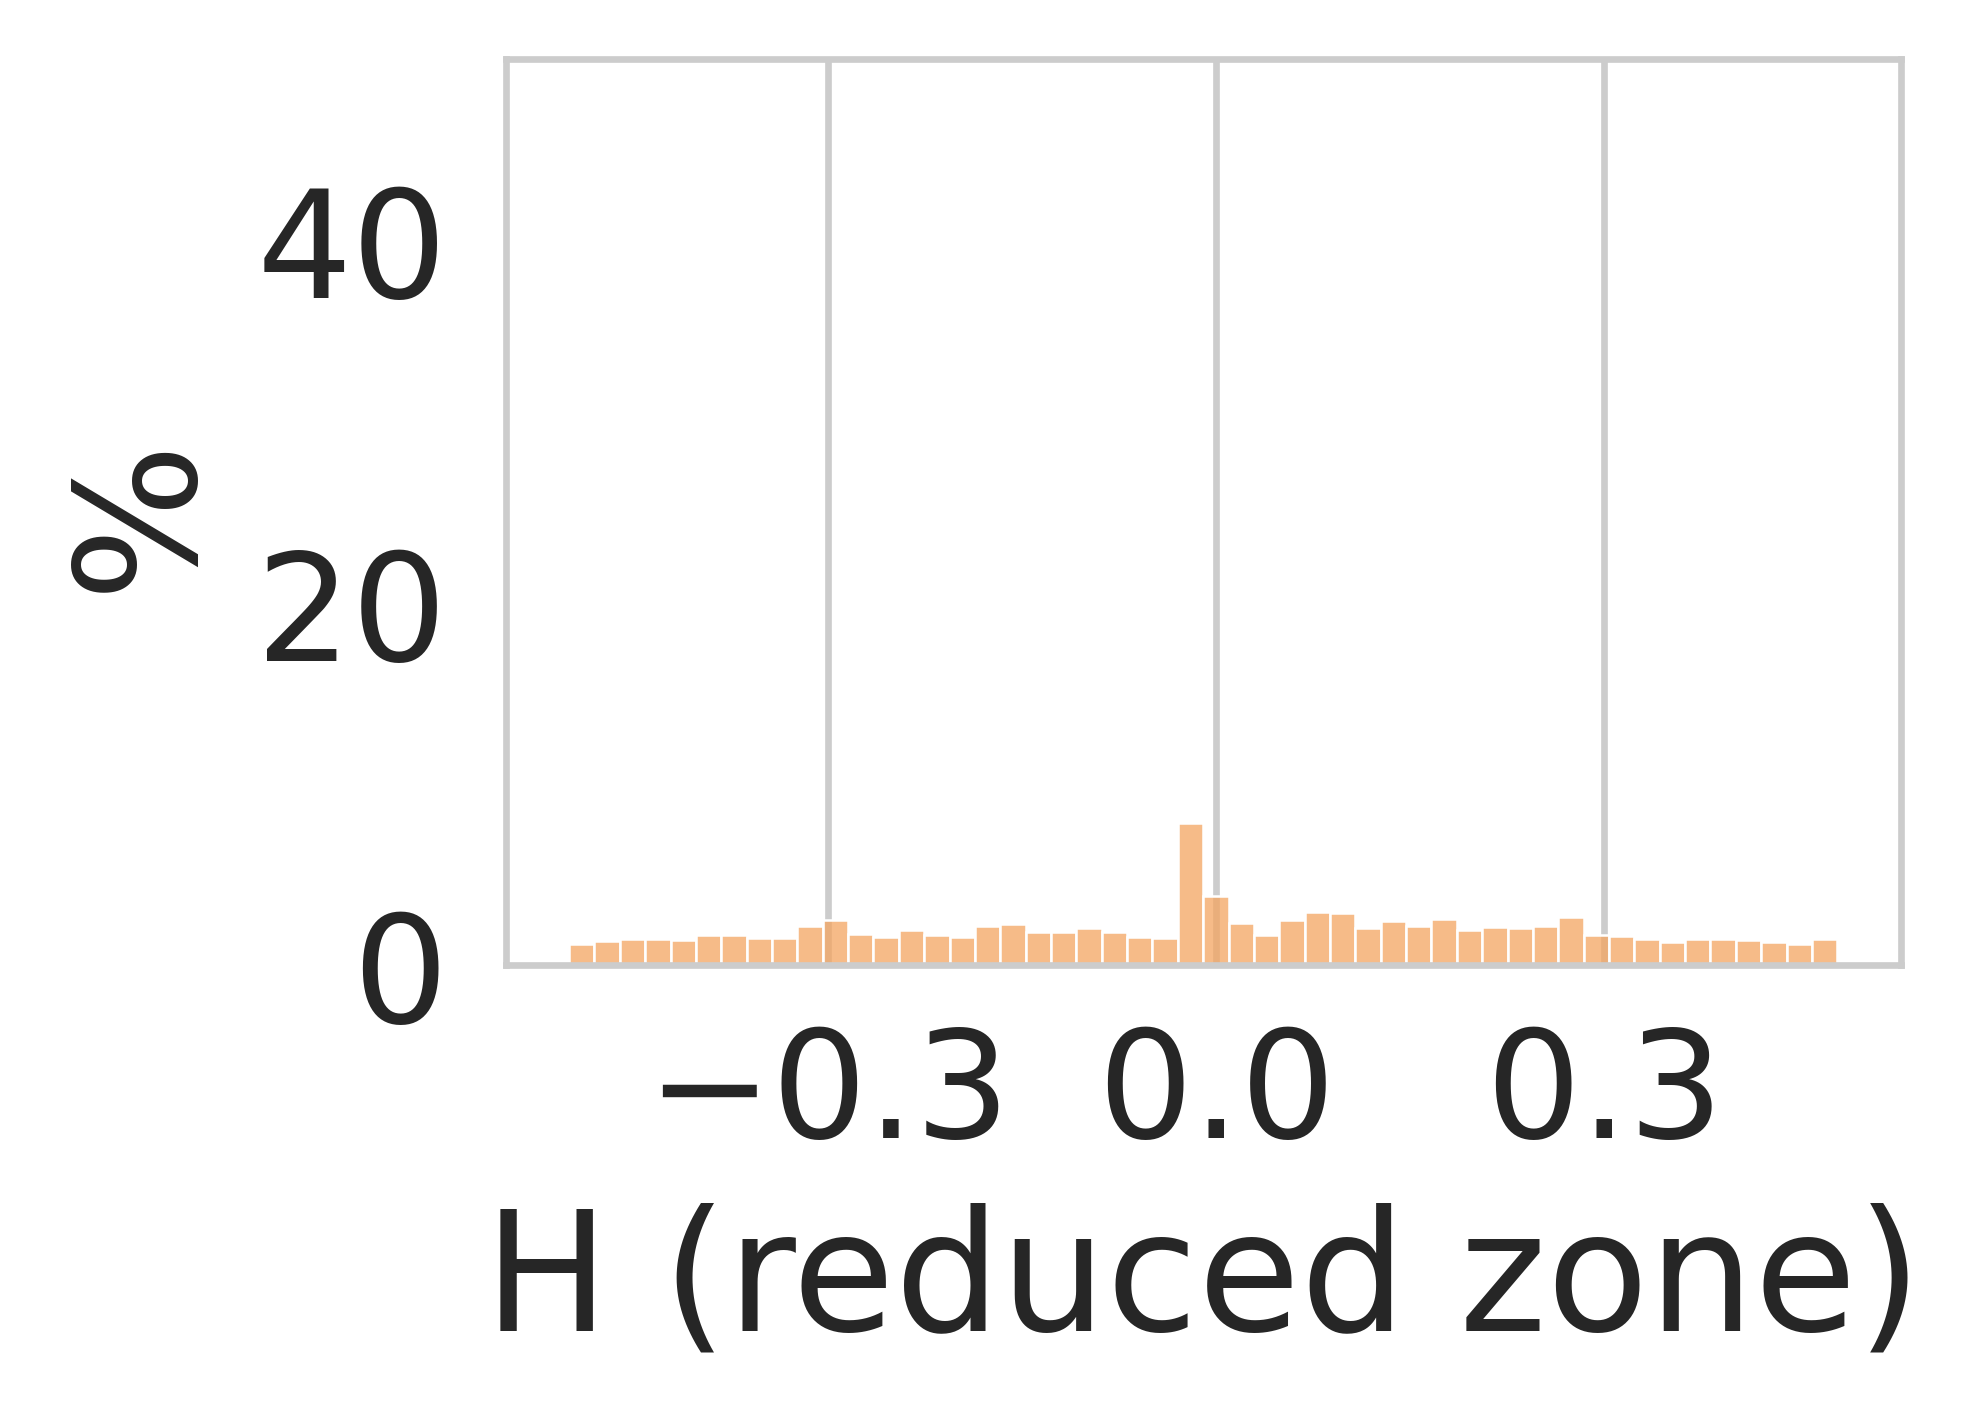

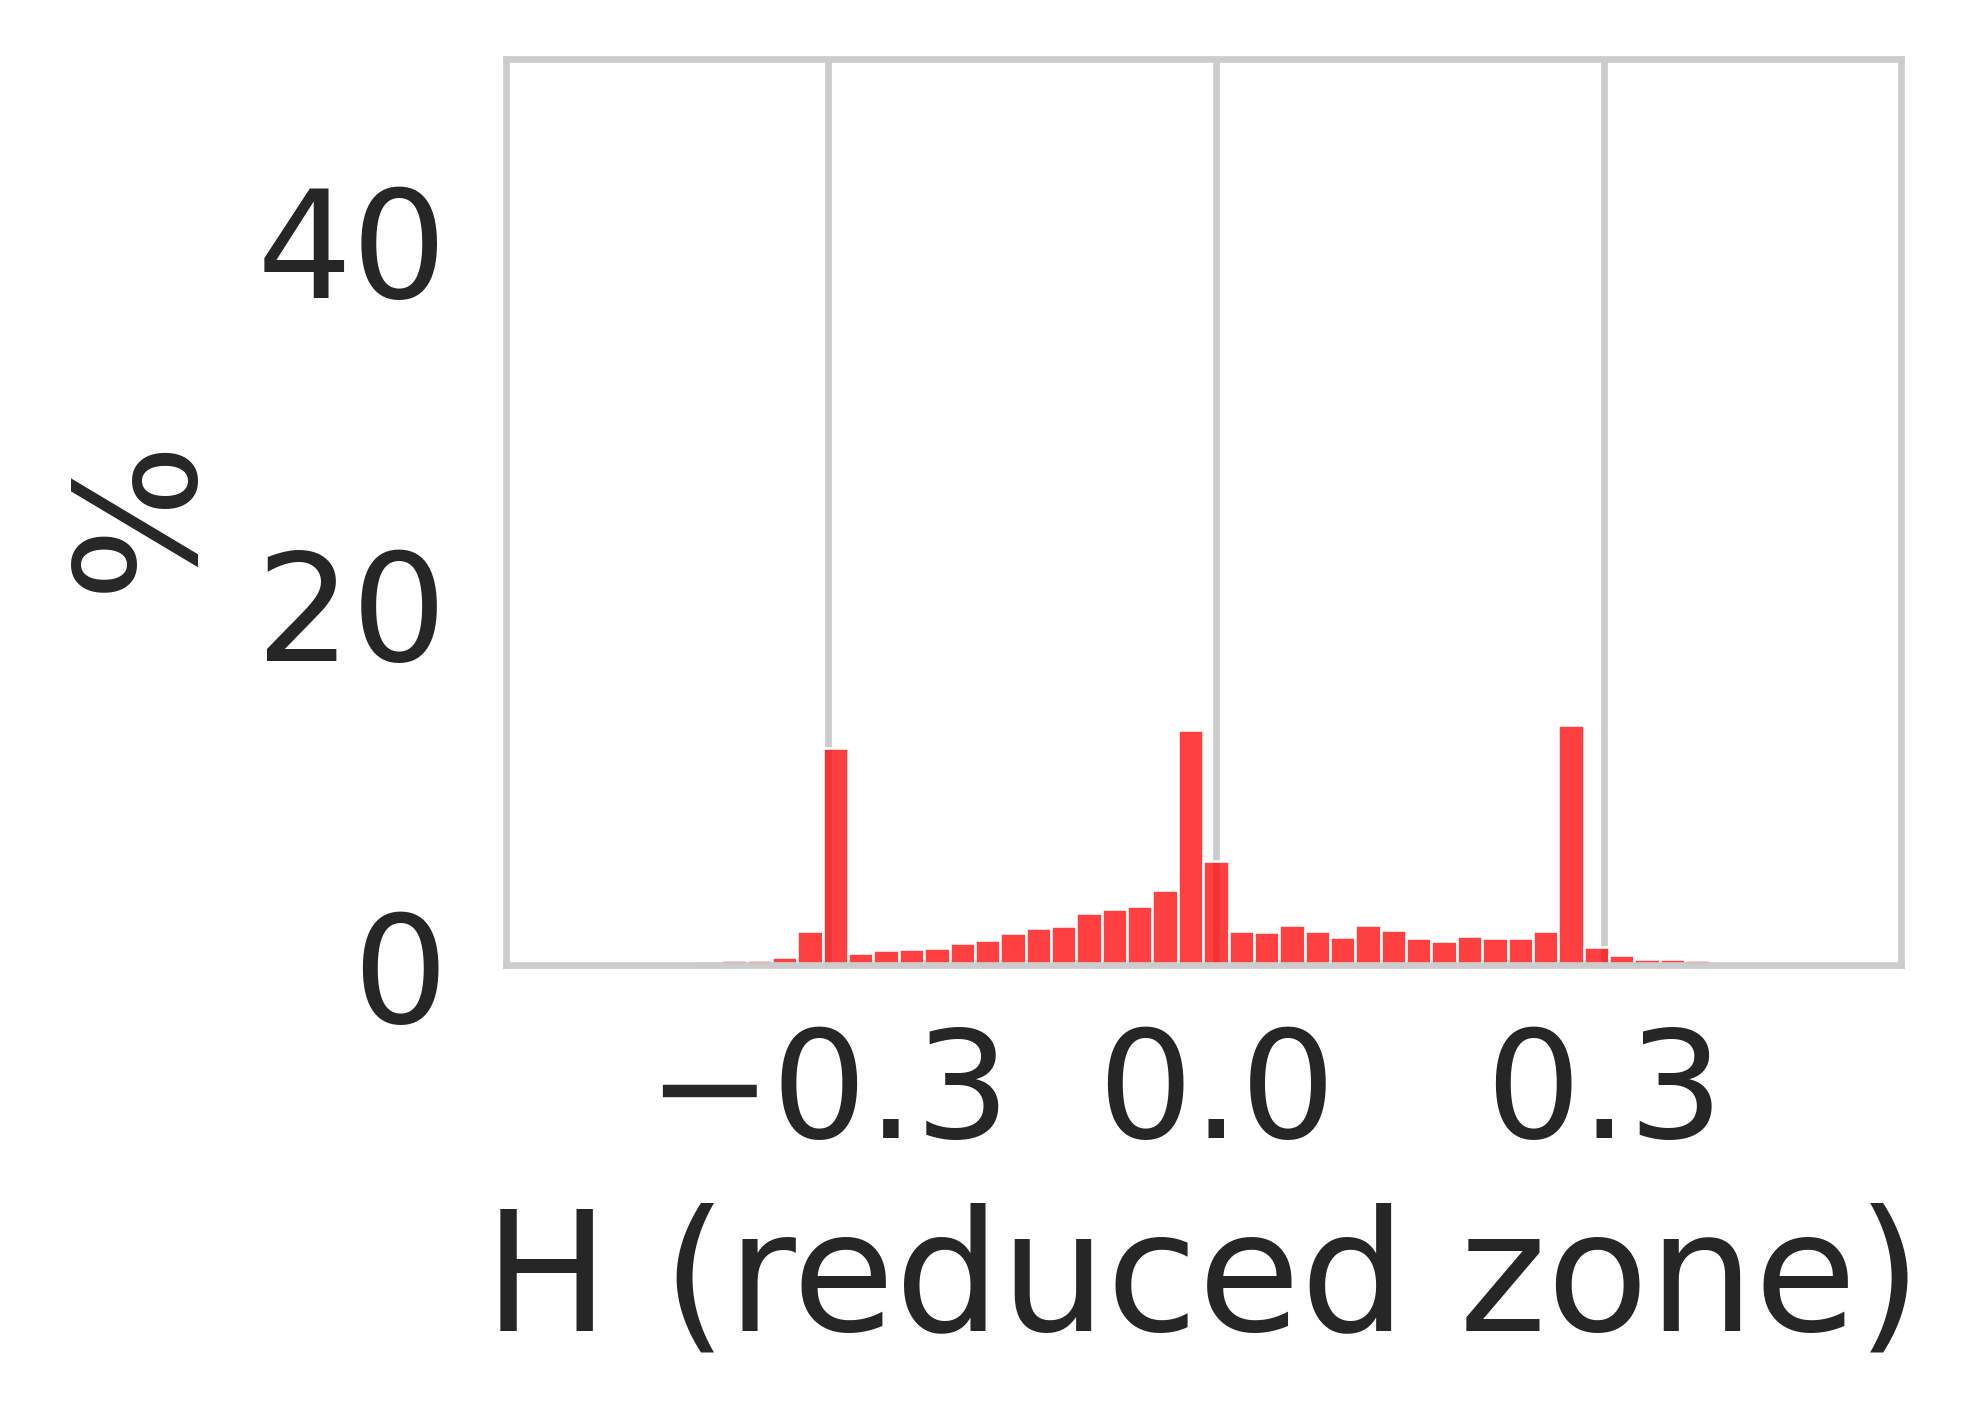

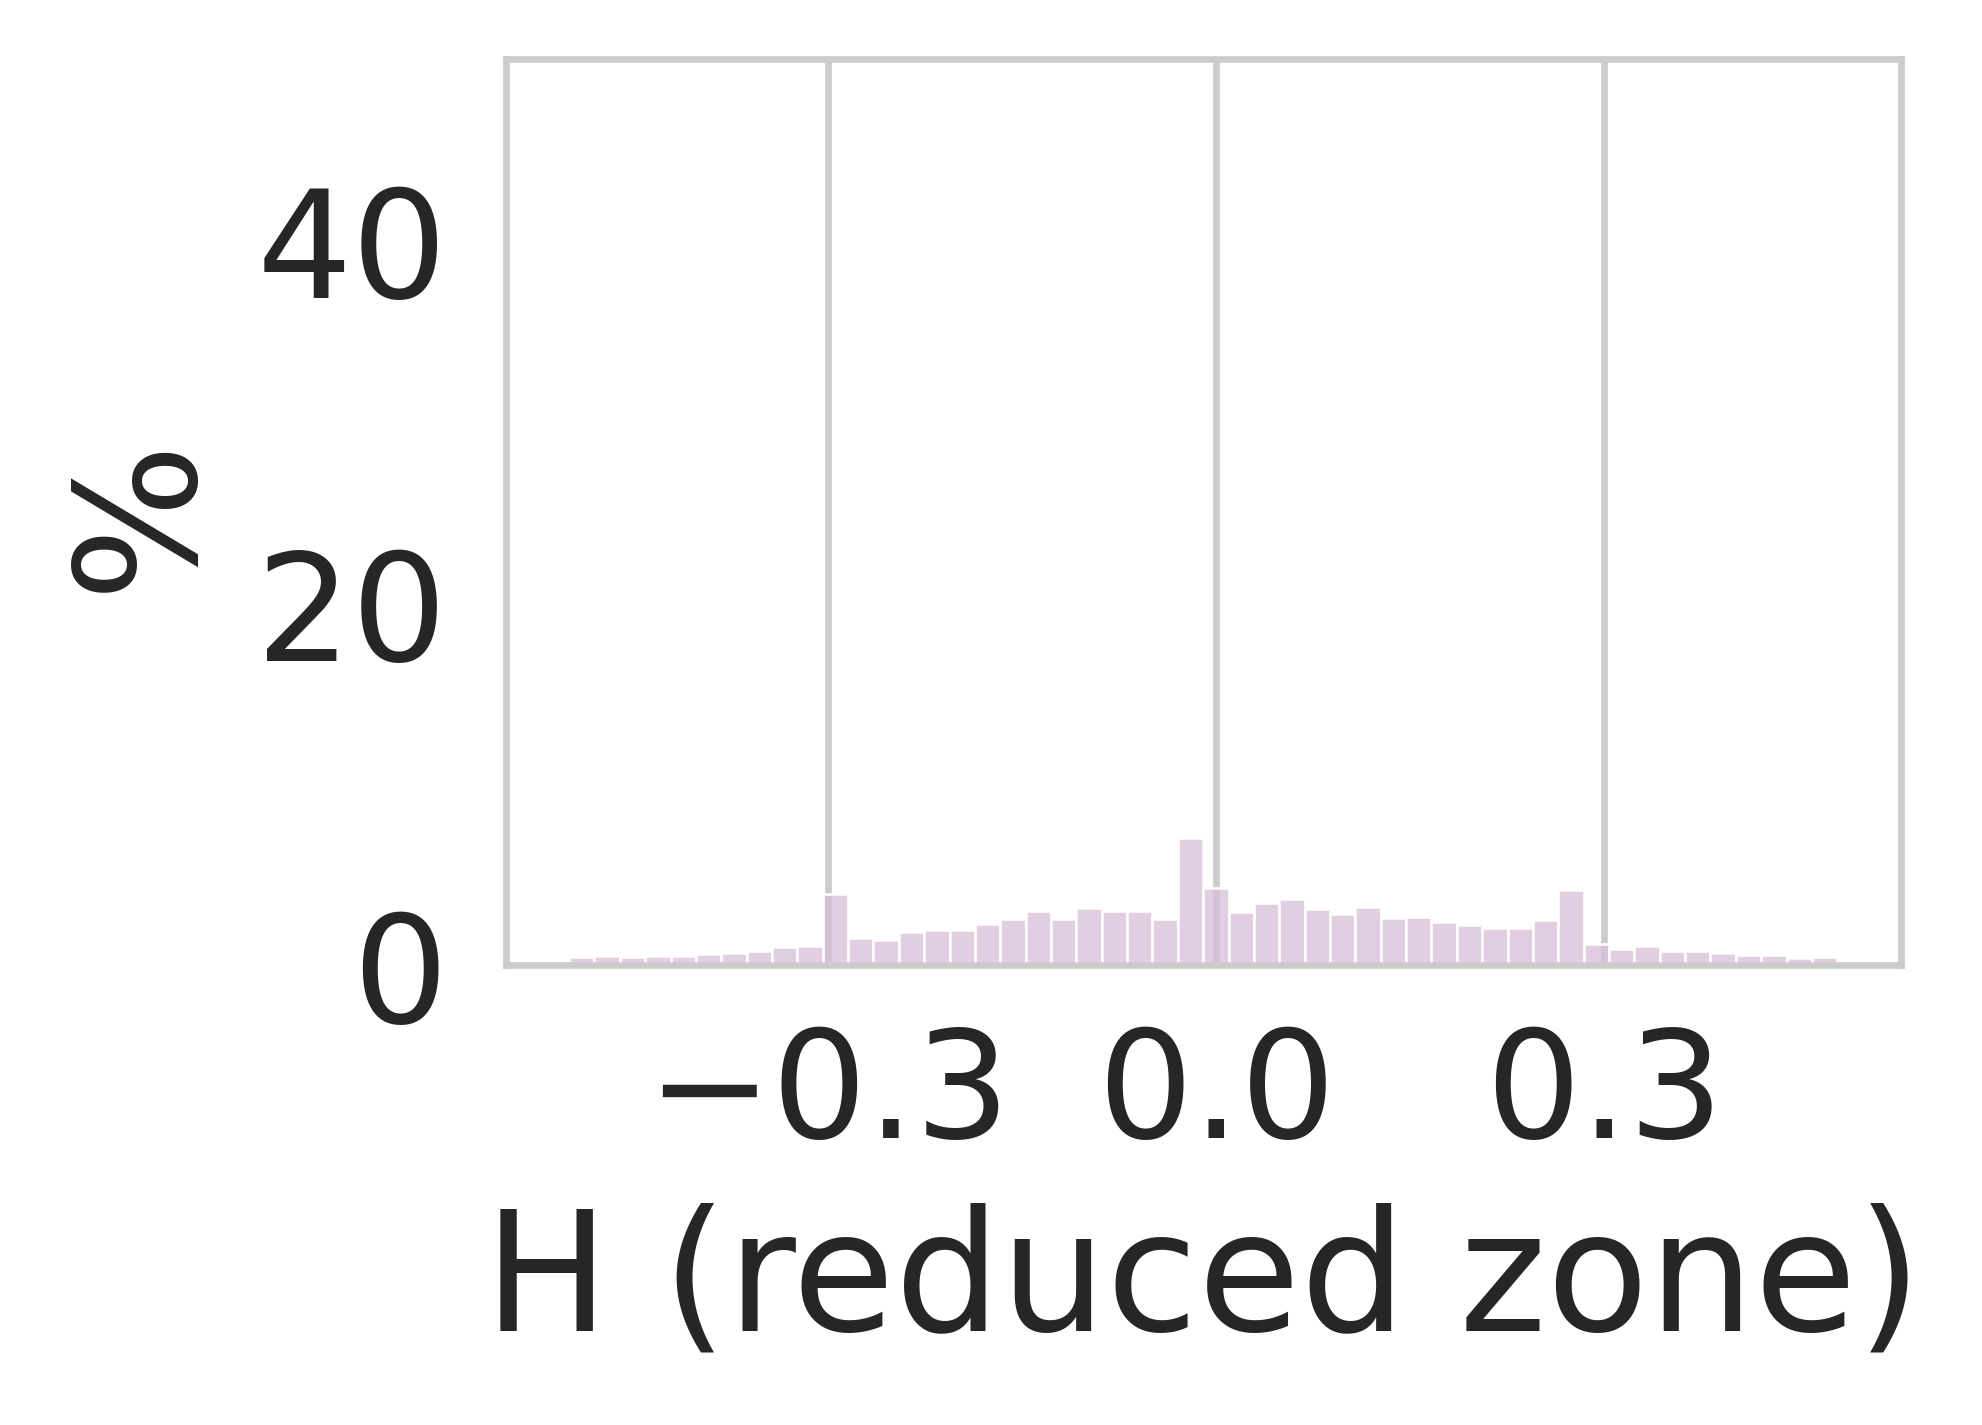

In [38]:
plot_1BZ_dist(H_axis=True)

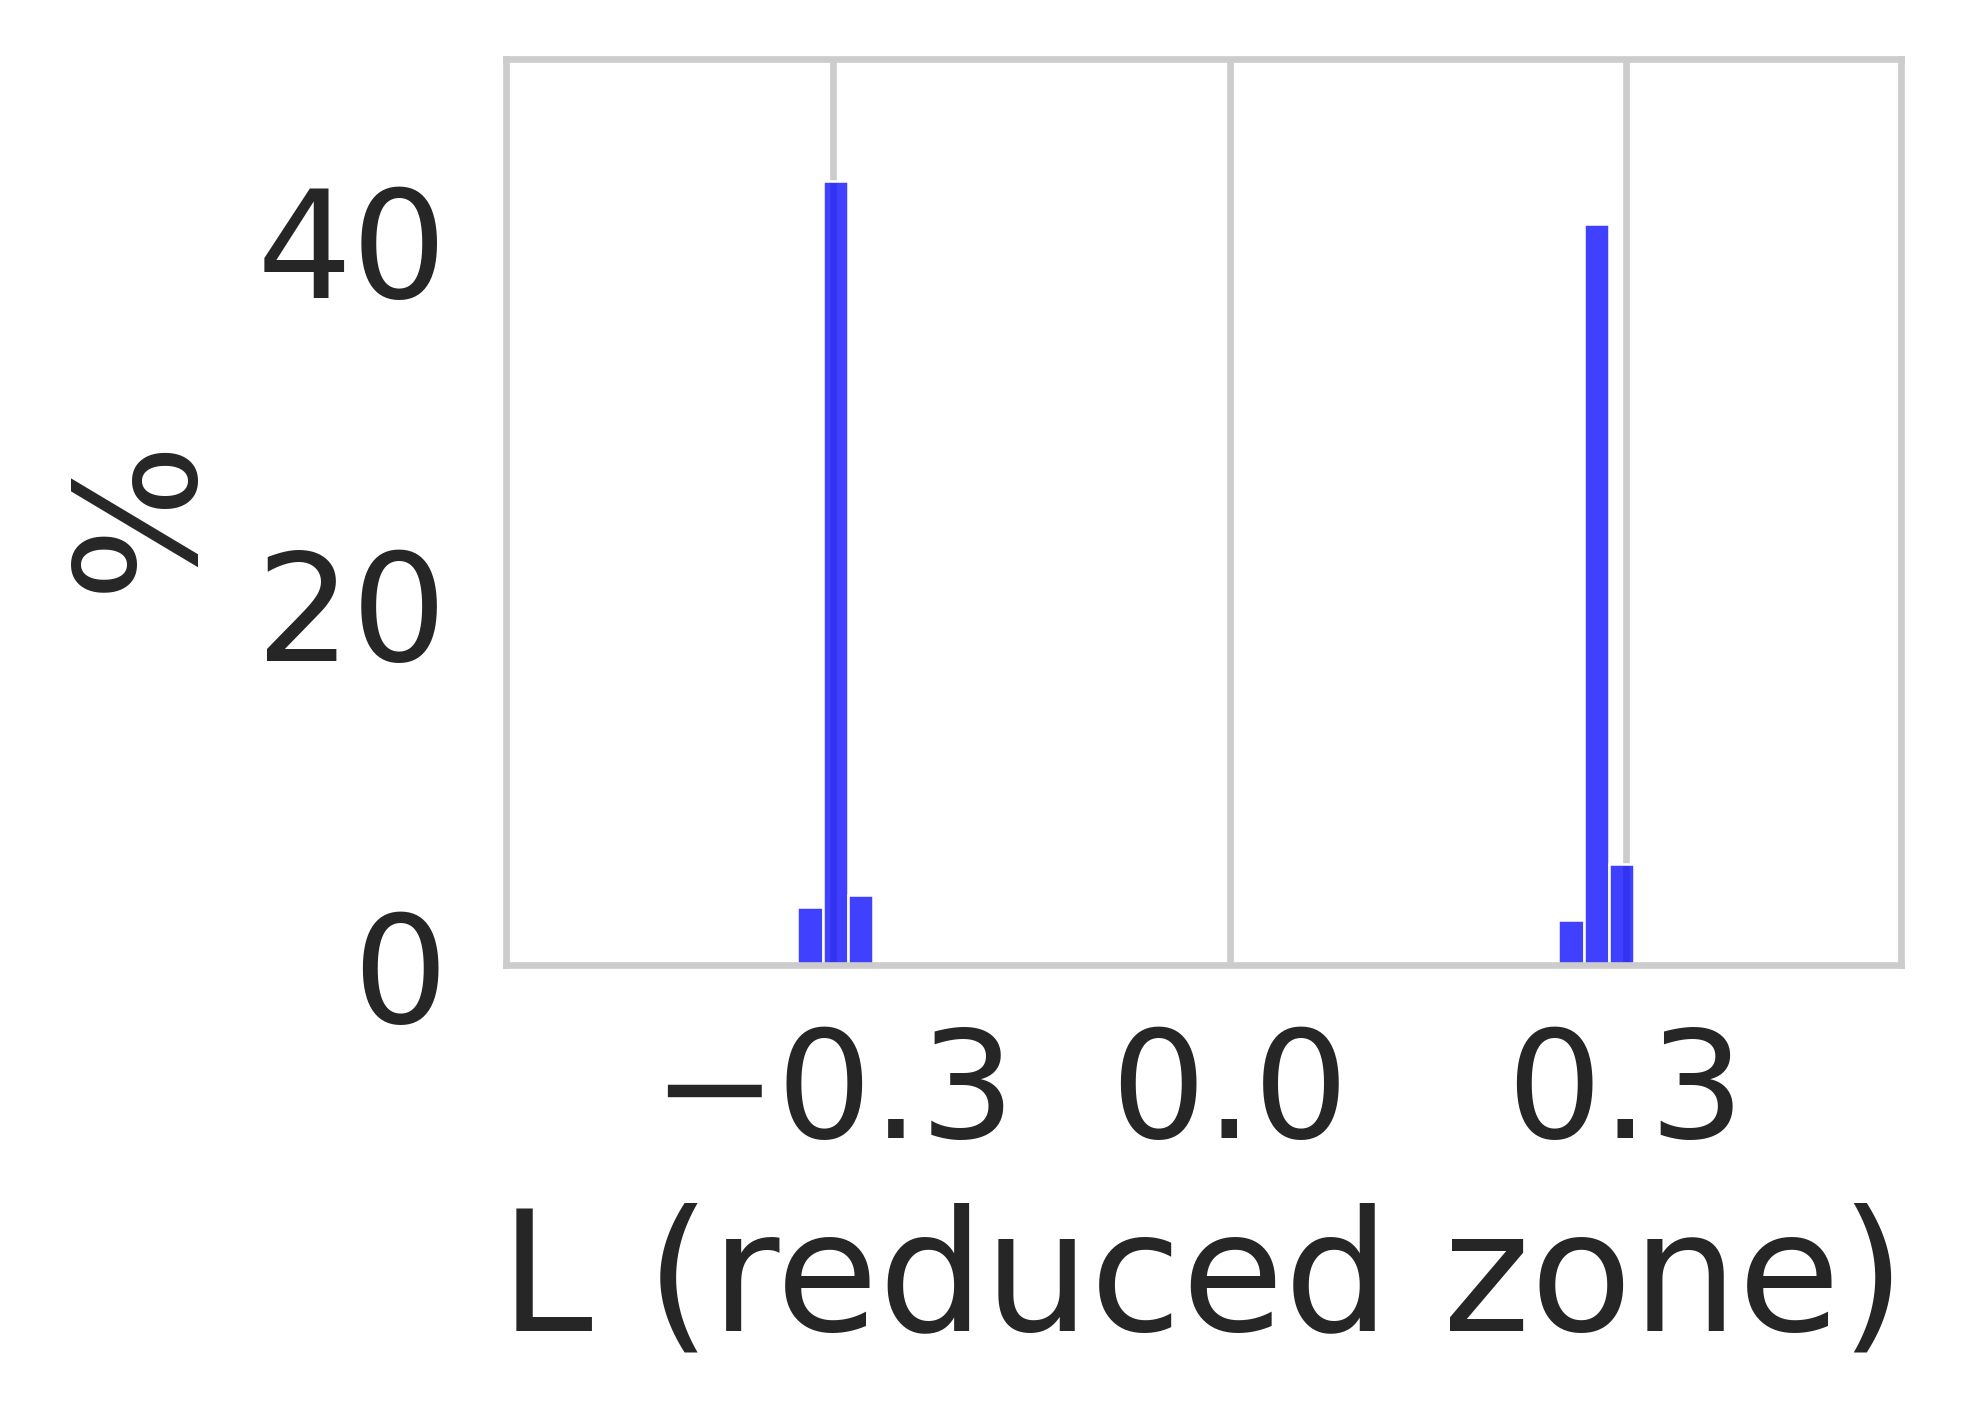

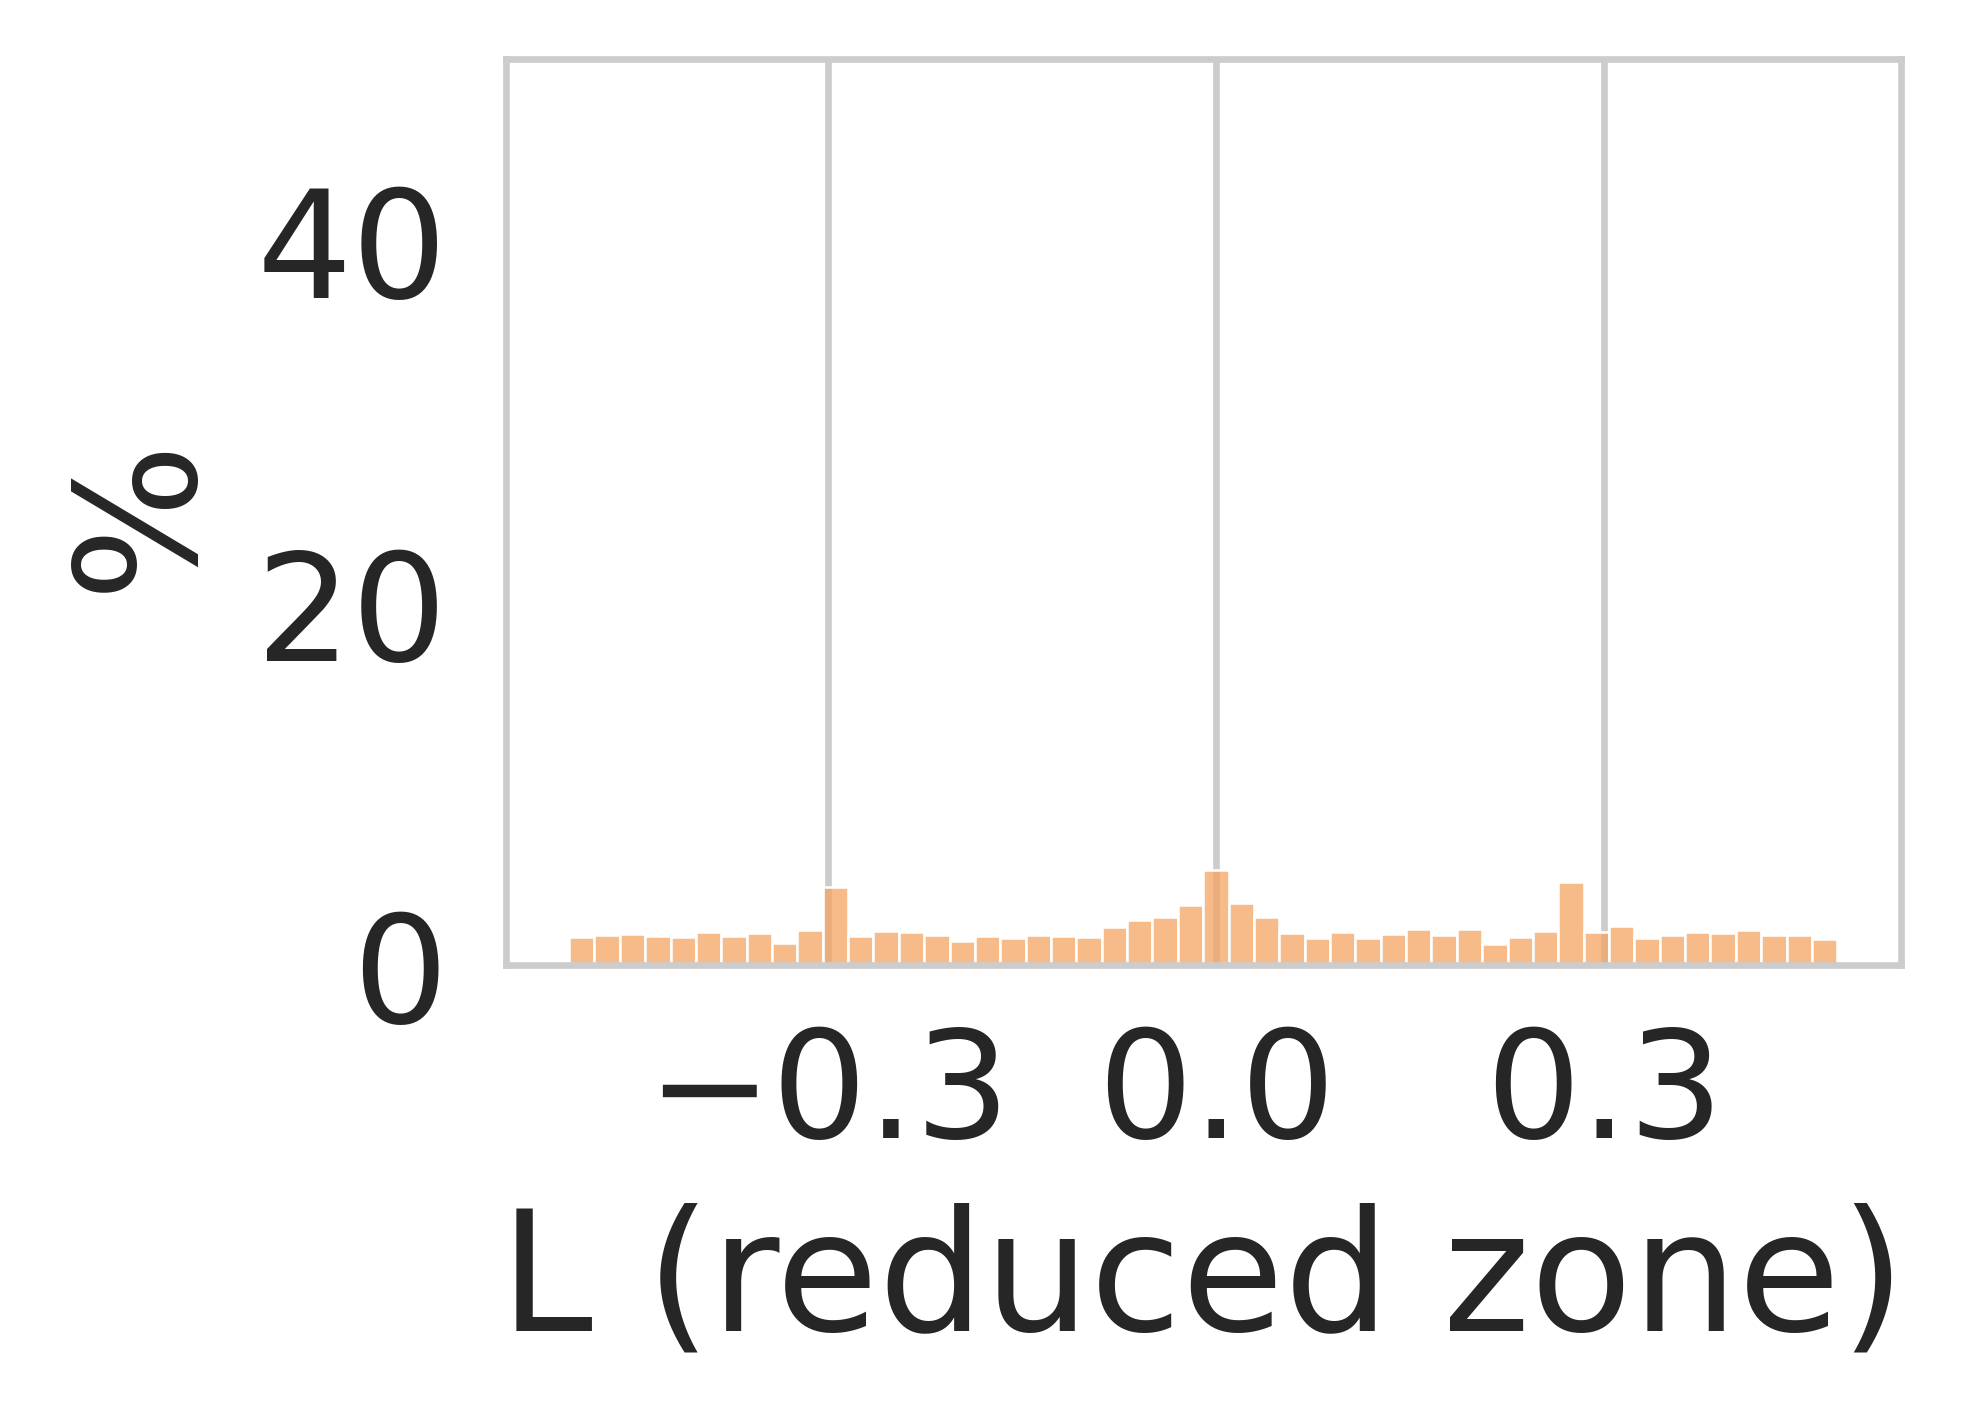

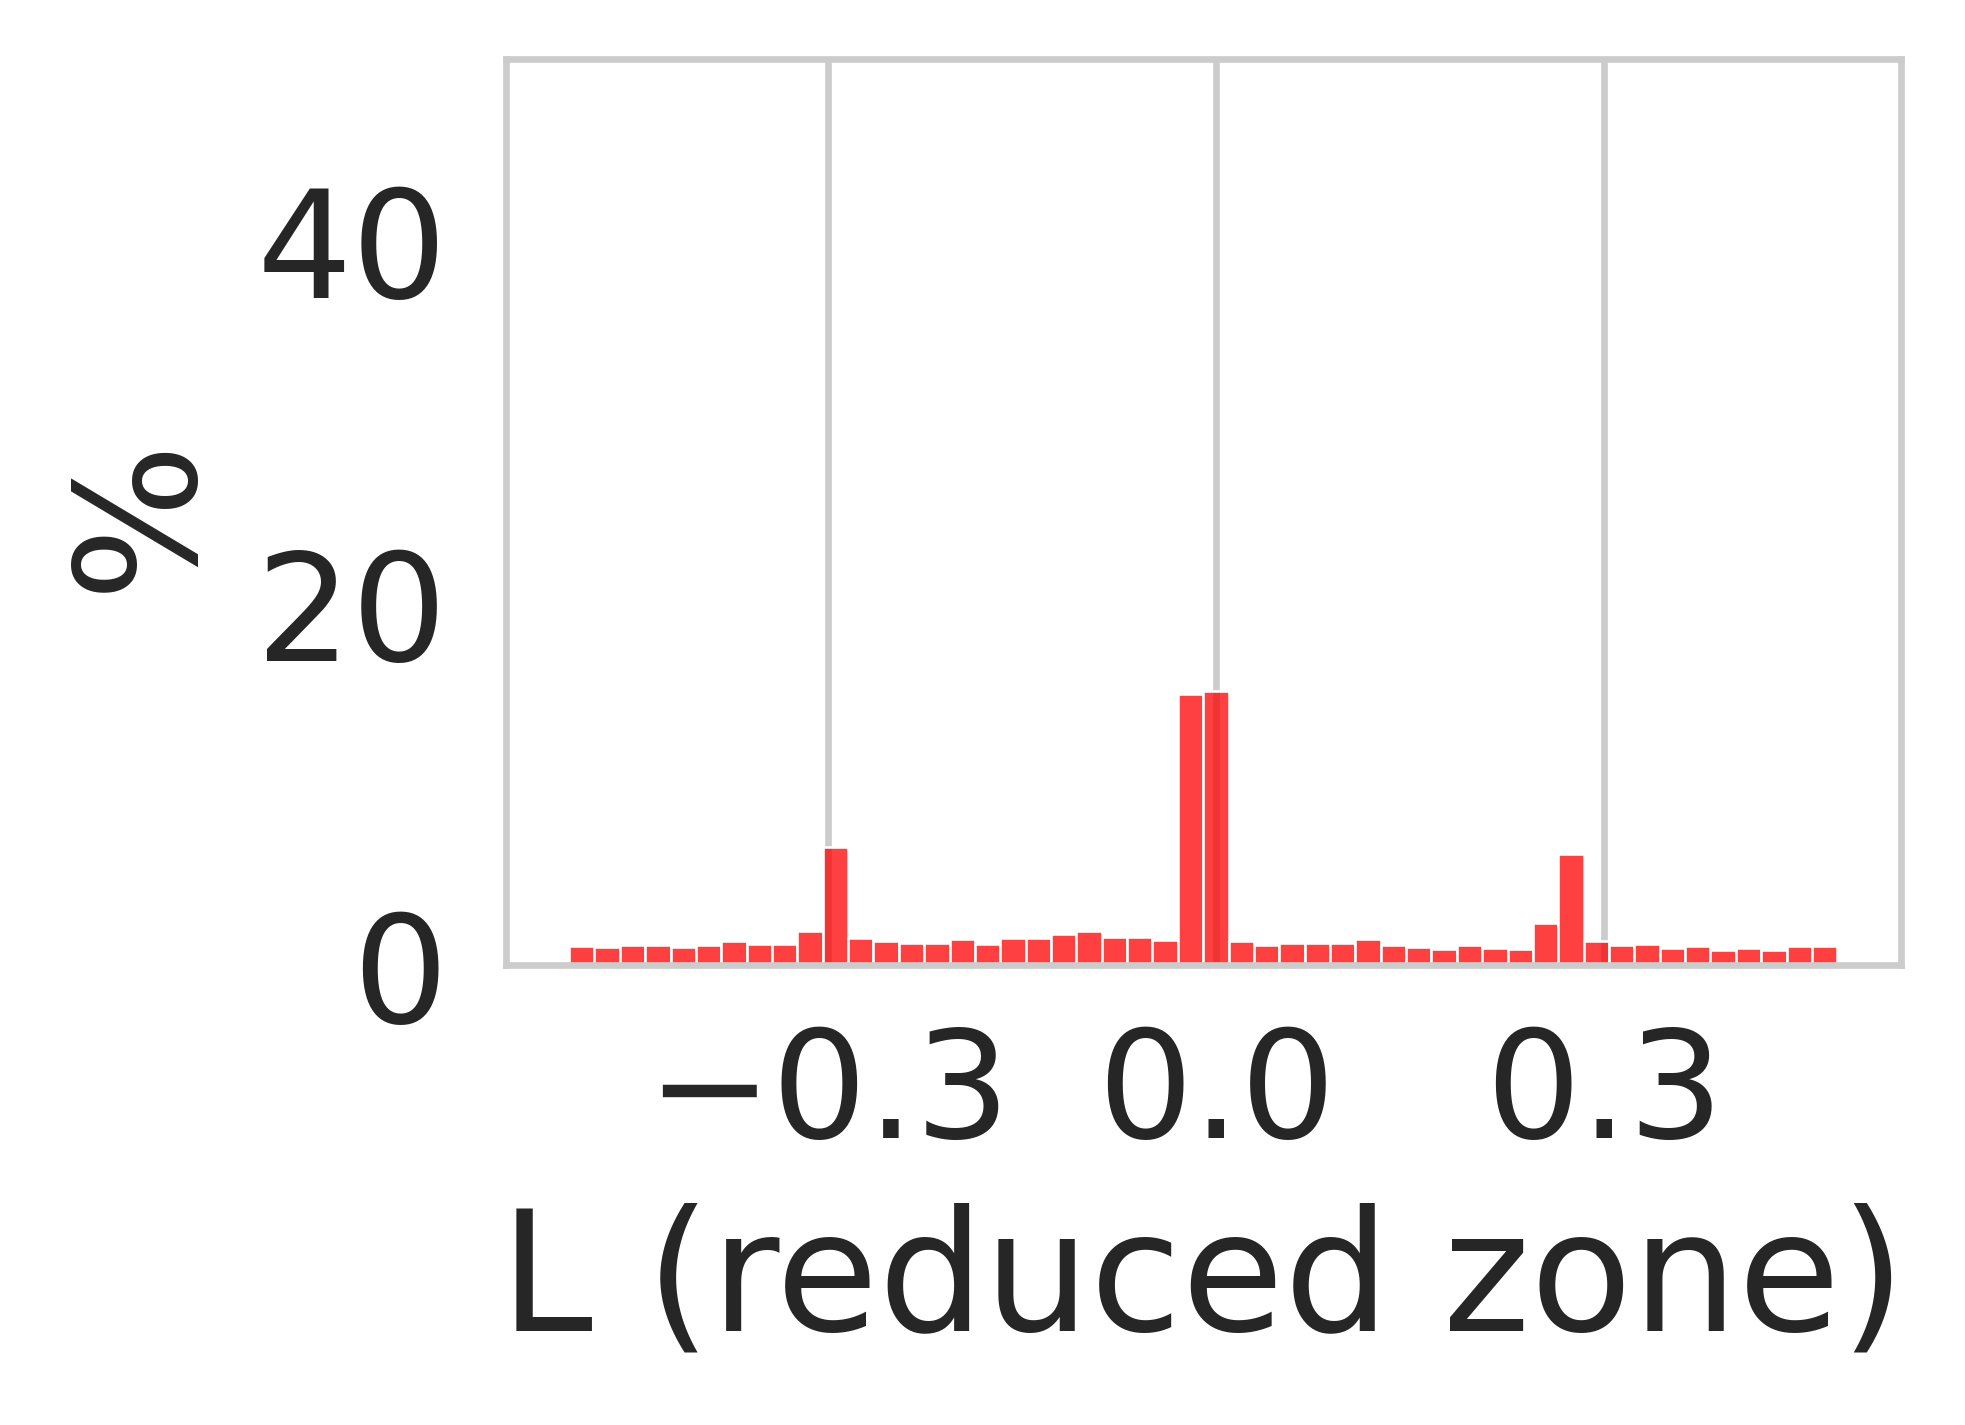

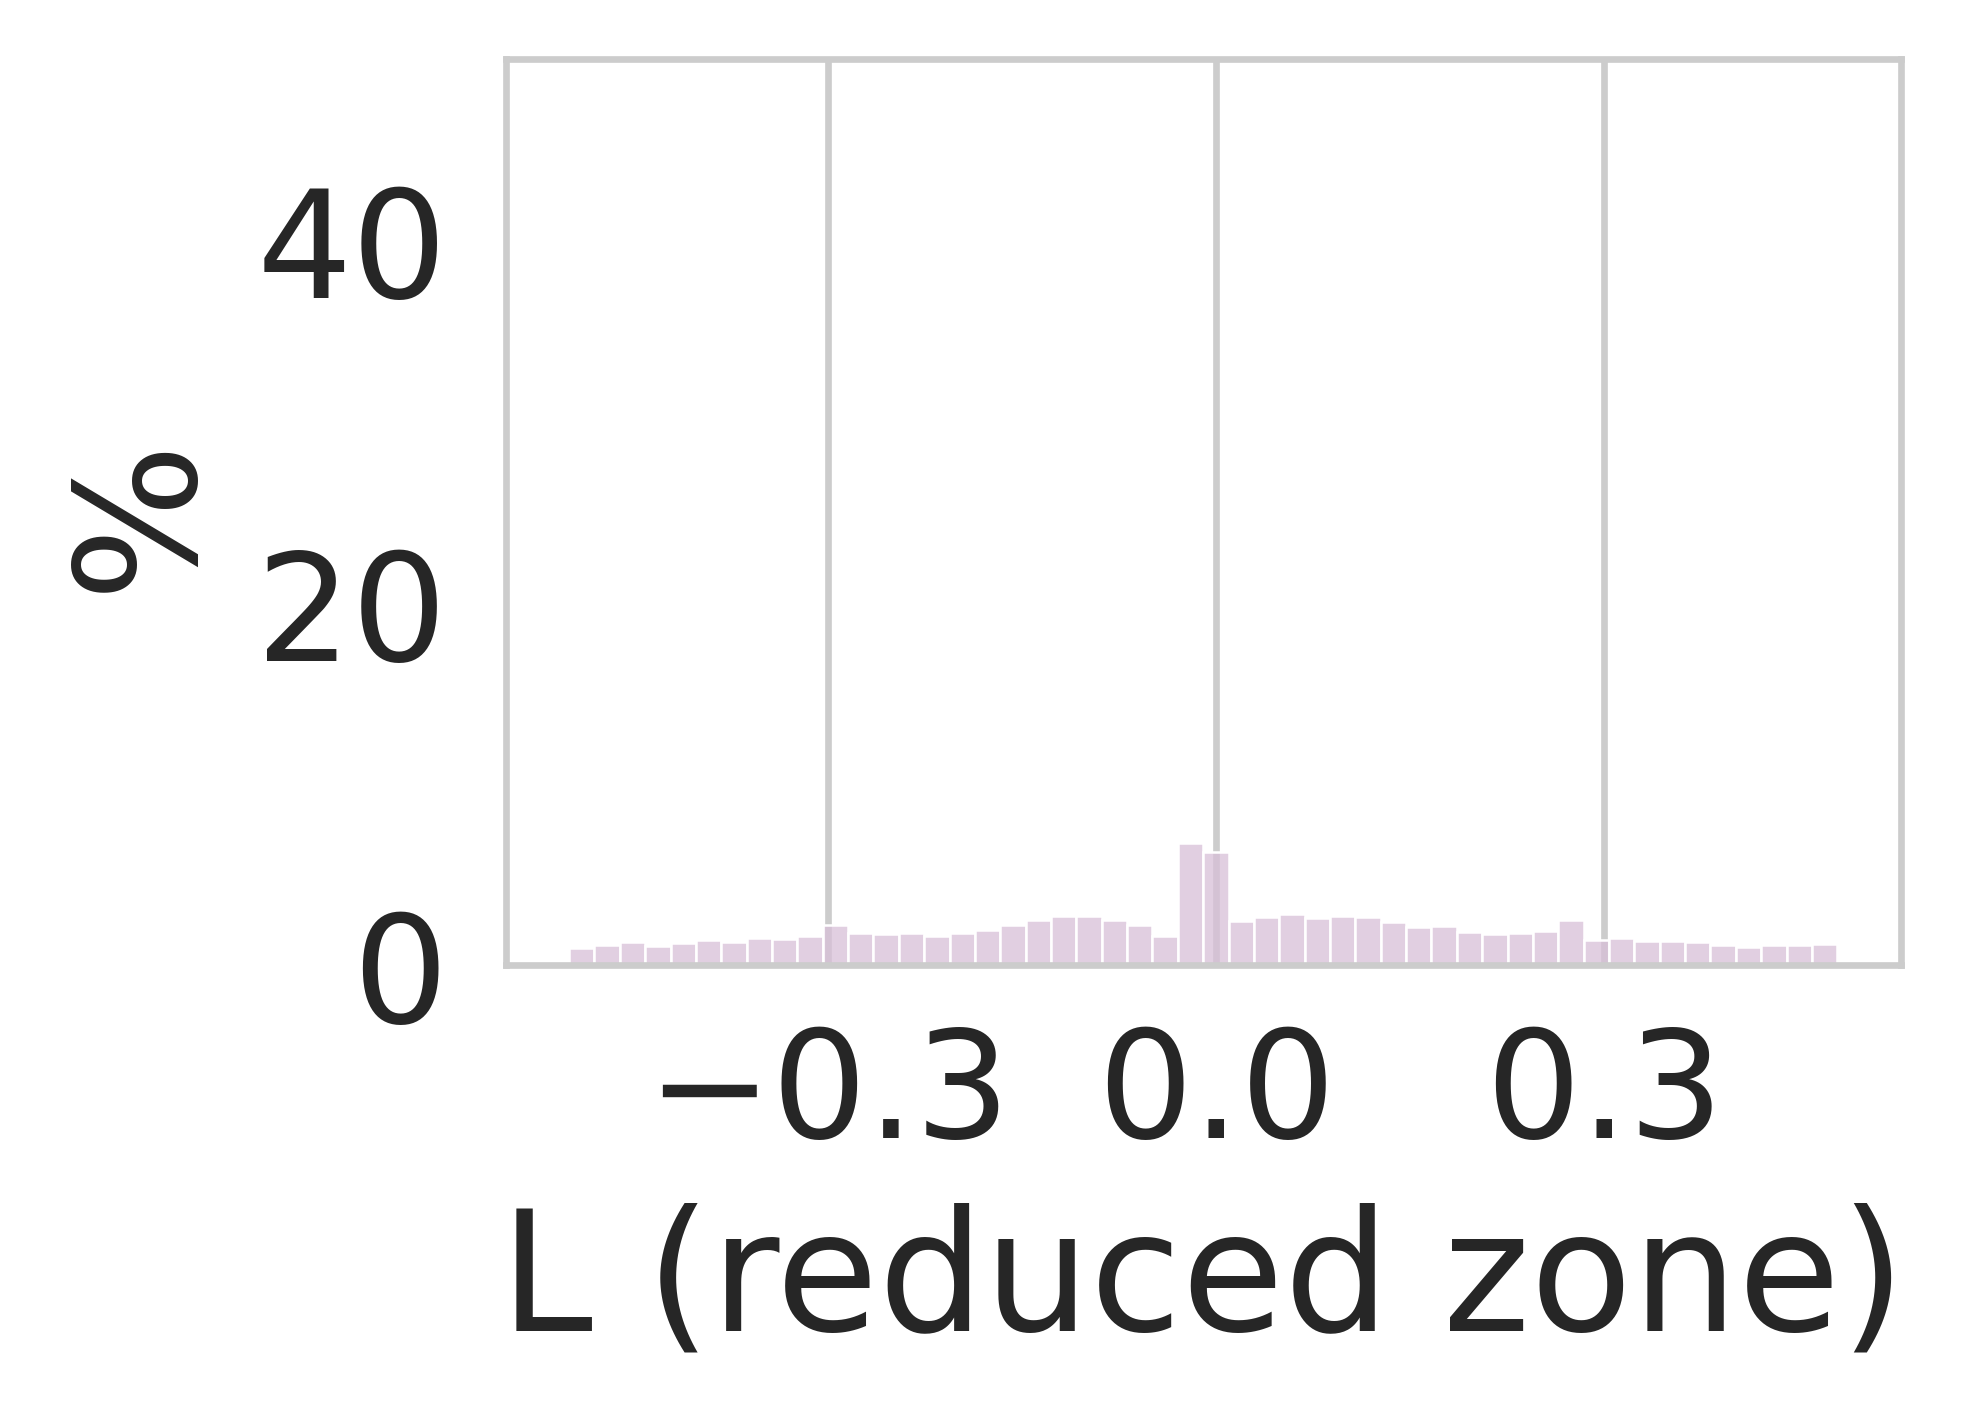

In [39]:
plot_1BZ_dist(H_axis=False)

# 2D Histogram

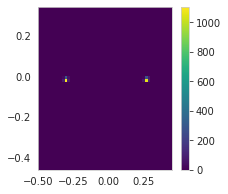

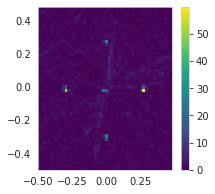

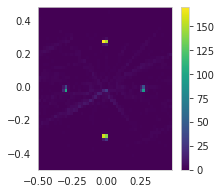

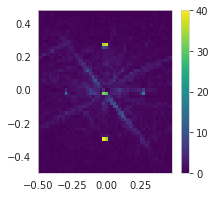

In [40]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})


h=Qh[NB_mom[:,0].astype(int)]+0.5
H_1BZ=np.mod(h,1)-0.5

l=Ql[NB_mom[:,1].astype(int)]+0.5
L_1BZ=np.mod(l,1)-0.5

import matplotlib.pyplot as plt
color_list = ['blue','sandybrown' , 'red', 'thistle', 'grey', 'orange', 'pink', 'black', 'grey', 'cyan']


for i in range(clusterGMM.cluster_num):
    cluster_mask_i = (clusterGMM.cluster_assignments == i)
    hc=H_1BZ[cluster_mask_i]
    lc=L_1BZ[cluster_mask_i]
    
    plt.figure(figsize=(3,3))
    #kde = stats.gaussian_kde(yc)

    plt.hist2d(hc,lc,bins=50,density=True,cmap='viridis');
    plt.colorbar()
    #x=np.linspace(0,1,100)
    #plt.plot(x,kde(x),color=color_list[i]);
    #sns.distplot(yc, bins=50,hist=True, kde=True,norm_hist=True, color=color_list[i], kde_kws={'linewidth': 4});

    